## Import

In [420]:
%matplotlib widget

In [421]:
from openmm.app import *
from openmm import *
import statistics
from openmm.unit import *
from sys import stdout
import plotly.express as px
import MDAnalysis.analysis.rms
import pandas as pd
from MDAnalysis.analysis.dihedrals import Dihedral
import mdtraj
import numpy as np
import MDAnalysis as mda
import ipywidgets
import matplotlib.pyplot as plt
import nglview

## SetUp

In [422]:
pdb = PDBFile("./1CRN.pdb")

In [423]:
forcefield = ForceField('charmm36.xml', 'charmm36/spce.xml')

In [424]:
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()
residues=modeller.addHydrogens(forcefield)

In [425]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=0.8*nanometer, constraints=HBonds)
integrator = openmm.CompoundIntegrator()
integrator.addIntegrator(LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds))
integrator.addIntegrator(VerletIntegrator(0.002*picosecond))
integrator.addIntegrator(AMDIntegrator(0.002*picosecond,11.20,-460*kilojoule_per_mole))
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [426]:
integrator.setCurrentIntegrator(0)

In [427]:
simulation.context.getState(getEnergy=True).getPotentialEnergy()

Quantity(value=-507.49973648615924, unit=kilojoule/mole)

In [428]:
print("Minimizing energy")
simulation.minimizeEnergy()

Minimizing energy


In [429]:
simulation.context.getState(getEnergy=True).getPotentialEnergy()

Quantity(value=-2098.9283899647817, unit=kilojoule/mole)

In [430]:
simulation.reporters.append(PDBReporter('NVT.pdb', 10000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))
simulation.reporters.append(StateDataReporter("NVT_md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))
simulation.reporters.append(DCDReporter("NVT.dcd",100))

In [431]:
print("Running NVT")
simulation.step(50000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-432.81031852789965,255.40770188810873,17.201564595860116
2000,-266.5661888701543,308.2775049777621,17.201564595860116
3000,-257.48094683714953,300.30028023920346,17.201564595860116
4000,-301.7665435654744,289.3611522821133,17.201564595860116
5000,-283.9346254450902,300.8904598768008,17.201564595860116
6000,-307.30803483553973,291.43993294529537,17.201564595860116
7000,-454.23094248601046,306.69698597842023,17.201564595860116
8000,-278.51693391629306,294.0283090541566,17.201564595860116
9000,-300.21809249945727,303.81857977891235,17.201564595860116
10000,-224.44817811080065,306.79763122323686,17.201564595860116
11000,-312.75413900443164,312.8537810826282,17.201564595860116
12000,-303.97521608897296,295.35552499145166,17.201564595860116
13000,-420.94803422518817,291.5095784697075,17.201564595860116
14000,-396.8472331149205,288.1446474296697,17.201564595860116
15000,-243.8991623503789,284.31235864

In [432]:
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation.context.reinitialize(preserveState=True)

In [433]:
simulation.reporters.append(PDBReporter('NPT.pdb', 10000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True, density=True))
simulation.reporters.append(StateDataReporter("NPT_md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, density=True))
simulation.reporters.append(DCDReporter("NPT.dcd",100))

In [434]:
print("Running NPT")
simulation.step(50000)

Running NPT
51000,-390.8635278327092,315.3955230251419,16.9232819479852
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
51000,-390.8635278327092,315.3955230251419,16.9232819479852,0.46415655189700605
52000,-382.3125452382192,293.43745219384004,17.059482287056028
52000,-382.3125452382192,293.43745219384004,17.059482287056028,0.4604507958437707
53000,-312.34721559115496,298.459643290806,16.774777698891903
53000,-312.34721559115496,298.459643290806,16.774777698891903,0.4682656507738127
54000,-449.78485590048876,307.1202738020655,16.72156226511629
54000,-449.78485590048876,307.1202738020655,16.72156226511629,0.46975587993619977
55000,-393.4296024424657,304.2370093459443,16.17692991519172
55000,-393.4296024424657,304.2370093459443,16.17692991519172,0.4855712571506534
56000,-541.9470317942723,309.87688678416214,16.05953200677938
56000,-541.9470317942723,309.87688678416214,16.05953200677938,0.4891208655670489
57000,-417.59992629119006,301.4689788845

In [435]:
simulation.reporters.append(PDBReporter('md_0_1.pdb', 10000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True, density=True))
simulation.reporters.append(StateDataReporter("md_0_1_md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, density=True))
simulation.reporters.append(DCDReporter("md_0_1.dcd",100))

### Classic MD

In [436]:
simulation.context.reinitialize(preserveState=True)
integrator.setCurrentIntegrator(1)
simulation.step(50000)

101000,-480.10042518206683,302.93069238553596,15.96008749081916
101000,-480.10042518206683,302.93069238553596,15.96008749081916,0.49216849220132264
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
101000,-480.10042518206683,302.93069238553596,15.96008749081916,0.49216849220132264
102000,-398.22991186209765,290.1036661788963,15.566618471905496
102000,-398.22991186209765,290.1036661788963,15.566618471905496,0.5046087697167108
102000,-398.22991186209765,290.1036661788963,15.566618471905496,0.5046087697167108
103000,-395.7979061586484,288.58364433247294,15.866711362110623
103000,-395.7979061586484,288.58364433247294,15.866711362110623,0.4950649202906254
103000,-395.7979061586484,288.58364433247294,15.866711362110623,0.4950649202906254
104000,-437.26407235690203,291.0200282734319,16.304815545926456
104000,-437.26407235690203,291.0200282734319,16.304815545926456,0.48176271443439533
104000,-437.26407235690203,291.0200282734319,16.304815545926456,0.48

In [437]:
traj = mdtraj.load("./md_0_1.dcd", top="md_0_1.pdb")
view = nglview.show_mdtraj(traj)
view

NGLWidget(max_frame=499)

#### Compute Energy

In [438]:
with open("md_0_1_md_log.txt",'r') as f :
    lines = [i.strip() for i in f.readlines()]

In [439]:
lines = [i.split(',') for i in lines]

In [440]:
data = np.array(lines)[1:].astype('float')

In [441]:
energy = data[:,1]

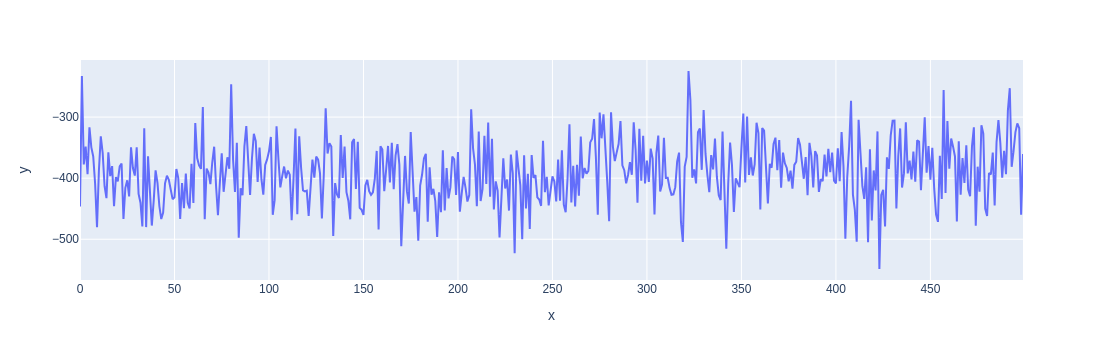

In [442]:
px.line(x=range(len(energy)),y=energy)

In [443]:
(20 * 100 )/-178.687069235526

-11.192751711450457

In [444]:
min(energy)

-548.7079197747335

In [445]:
(-578.687069235526)-(-400)

-178.687069235526

### Draw Ramachandran classic md

In [446]:
ua = mda.Universe("./md_0_1.pdb", "./md_0_1.dcd")

/home/defense/leonfounlin/micromamba/envs/openmm/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning:

DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.



In [447]:
ra = ua.select_atoms("backbone")

In [448]:
from MDAnalysis.analysis.dihedrals import Ramachandran
Ra = Ramachandran(ra).run()

/home/defense/leonfounlin/micromamba/envs/openmm/lib/python3.12/site-packages/MDAnalysis/analysis/dihedrals.py:400: UserWarning:

Cannot determine phi and psi angles for the first or last residues



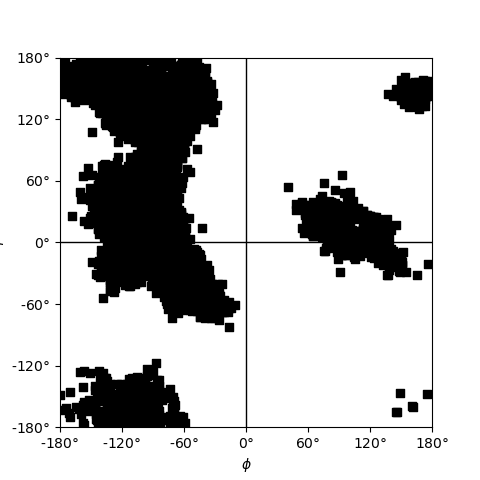

In [449]:
fig, ax = plt.subplots(figsize=plt.figaspect(1))
Ra.plot(ax=ax, color='k', marker='s')
plt.show()

### Accelerated md

In [450]:
simulation.reporters.append(PDBReporter('Amd_0_1.pdb', 10000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True, density=True))
simulation.reporters.append(StateDataReporter("Amd_0_1_md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, density=True))
simulation.reporters.append(DCDReporter("Amd_0_1.dcd",100))

In [451]:
integrator.setCurrentIntegrator(2)
simulation.step(500000)

151000,-223.43728846140948,299.18116454625294,16.022753911738608
151000,-223.43728846140948,299.18116454625294,16.022753911738608,0.49024357729184614
151000,-223.43728846140948,299.18116454625294,16.022753911738608,0.49024357729184614
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
151000,-223.43728846140948,299.18116454625294,16.022753911738608,0.49024357729184614
152000,-263.38538938590136,316.42012759830914,16.035221090883727
152000,-263.38538938590136,316.42012759830914,16.035221090883727,0.48986241918568724
152000,-263.38538938590136,316.42012759830914,16.035221090883727,0.48986241918568724
152000,-263.38538938590136,316.42012759830914,16.035221090883727,0.48986241918568724
153000,-261.09008532591906,309.58598632052895,16.225341094819125
153000,-261.09008532591906,309.58598632052895,16.225341094819125,0.48412246928145225
153000,-261.09008532591906,309.58598632052895,16.225341094819125,0.48412246928145225
153000,-261.09008532591906,309.58

### Draw Ramachandran aMD

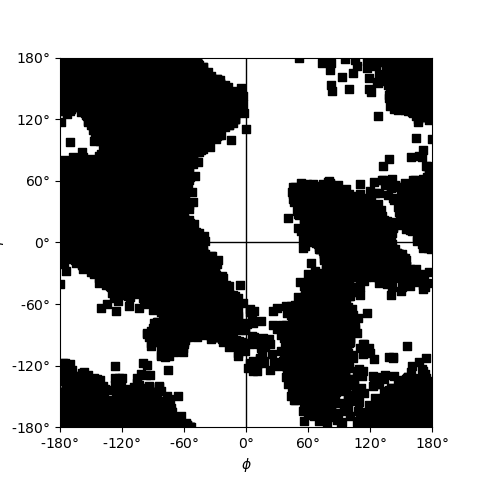

In [452]:
ub = mda.Universe("./Amd_0_1.pdb", "./Amd_0_1.dcd")
rb = ub.select_atoms("backbone")
Rb = Ramachandran(rb).run()
fig, ax = plt.subplots(figsize=plt.figaspect(1))
Rb.plot(ax=ax, color='k', marker='s')
plt.show()

In [453]:
# RMSD

In [454]:
Ra = MDAnalysis.analysis.rms.RMSD(ua, ua,select="backbone")
Rb = MDAnalysis.analysis.rms.RMSD(ub, ub,select="backbone")

In [456]:
Ra.run()
Rb.run()

/home/defense/leonfounlin/micromamba/envs/openmm/lib/python3.12/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning:

The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.



Text(0, 0.5, 'RMSD ($\\AA$)')

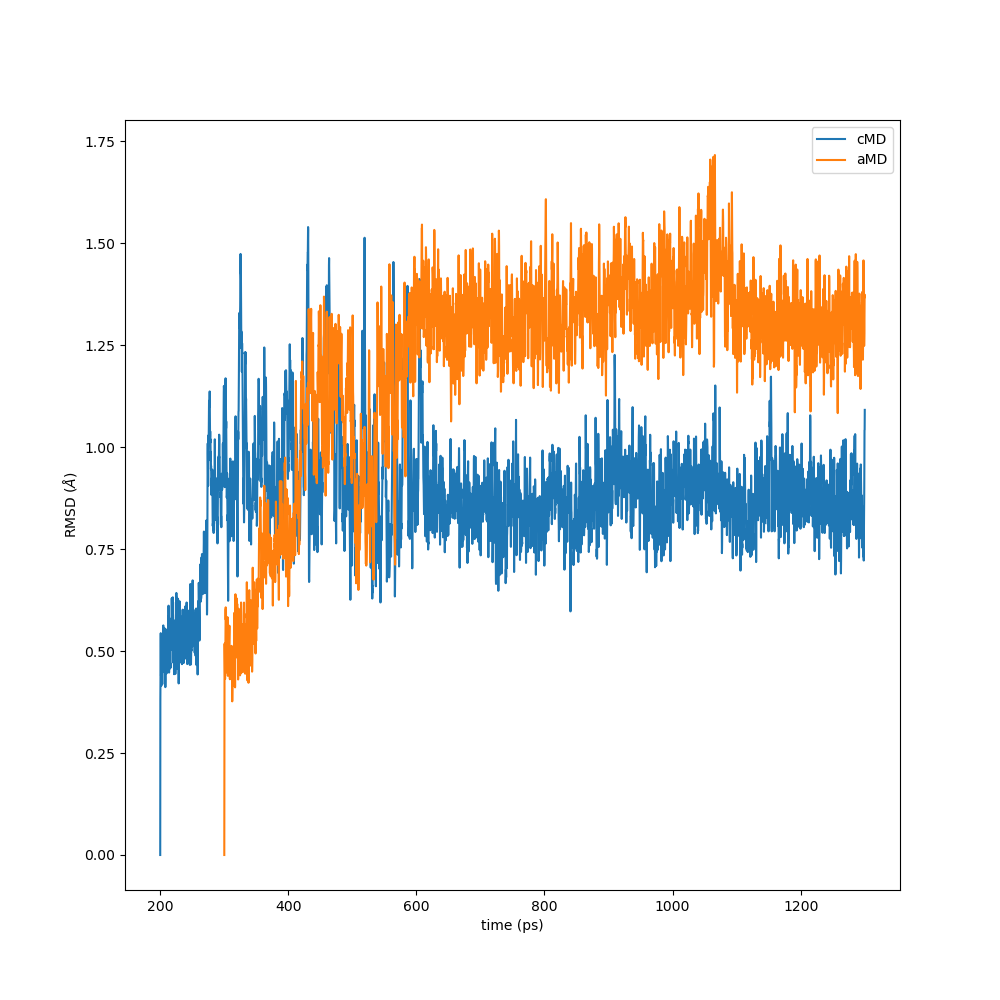

In [457]:
rmsdb = Rb.rmsd.T   # transpose makes it easier for plotting
timeb = rmsdb[1]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(timea, rmsda[2],  label="cMD")
ax.plot(timeb, rmsdb[2],  label="aMD")
ax.legend(loc="best")
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"RMSD ($\AA$)")

In [458]:
# RMSF